### Objective

Collisions at high-energy particle colliders are a traditionally fruitful source of exotic particle discoveries. Finding these rare particles requires solving difficult signal-versus-background classification. The objective of this notebook is one were we try to apply various Machine Learning akgortihms on the Monto-Carlo simualted data, to try to classify the data as either `signal` or `background`

The Data is named `SUSY` data, which is available at the UCI Machine Learning repository [Link](https://archive.ics.uci.edu/ml/datasets/SUSY).

### Imports

In [22]:
# Redaing and Manipulating Data
import pandas as pd
import numpy as np

# Visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Classification Models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Classification Model from XGBoost
from xgboost import XGBClassifier

# Hyper Parameter Optimization
import optuna

In [ ]:
!pip install -U -qq --no-cache-dir gdown --pre

In [ ]:
!pip install -qq optuna

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1_FZIrNug8svcEK5QMDdV2MoHmcCny8kJ&export=download"
output = "train.csv"
gdown.download(url, output)

url = "https://drive.google.com/uc?id=1_FAidr3sAiSWx6mPS26HMpWjVaiSTOXq&export=download"
output = "test.csv"
gdown.download(url, output)

In [ ]:
df = pd.read_csv("./train.csv", index_col=0)
df.head()

### Data Exploration

In [20]:
df.describe()

lepton_1_pT  lepton_1_eta  lepton_1_phi   lepton_2_pT  lepton_2_eta  \
count  3.500000e+06  3.500000e+06  3.500000e+06  3.500000e+06  3.500000e+06   
mean   1.000232e+00  3.599349e-04  3.409634e-04  9.992382e-01  3.546249e-04   
std    6.873955e-01  1.003109e+00  1.001971e+00  6.537354e-01  1.002817e+00   
min    2.548815e-01 -2.102919e+00 -1.734789e+00  4.285860e-01 -2.059306e+00   
25%    5.625003e-01 -7.569637e-01 -8.673235e-01  5.969753e-01 -7.693463e-01   
50%    7.913588e-01  6.139759e-04 -3.000550e-04  7.997329e-01  1.132228e-04   
75%    1.204264e+00  7.581109e-01  8.681473e-01  1.161961e+00  7.698279e-01   
max    2.055345e+01  2.101605e+00  1.734839e+00  3.303562e+01  2.059721e+00   

       lepton_2_phi  missing_energy_magnitude  missing_energy_phi  \
count  3.500000e+06              3.500000e+06        3.500000e+06   
mean  -2.609503e-04              9.994536e-01       -4.940216e-04   
std    1.001447e+00              8.724024e-01        1.001655e+00   
min   -1.734202e+00              7.199480e-04       -1.727112e+00   
25%   -8.680870e-01              4.781798e-01       -8.663442e-01   
50%   -3.504302e-04              7.734768e-01       -1.038813e-02   
75%    8.670100e-01              1.206897e+00        8.681880e-01   
max    1.734686e+00              2.106888e+01        1.740689e+00   

            MET_rel     axial_MET           M_R        M_TR_2             R  \
count  3.500000e+06  3.500000e+06  3.500000e+06  3.500000e+06  3.500000e+06   
mean   1.000944e+00 -8.176786e-05  1.000253e+00  9.996171e-01  9.998163e-01   
std    8.897569e-01  1.000707e+00  6.286597e-01  5.839003e-01  4.711496e-01   
min    7.693475e-08 -1.533509e+01  2.680643e-01  2.427395e-03  4.528082e-03   
25%    3.689606e-01 -4.920890e-01  5.883102e-01  6.222096e-01  6.503162e-01   
50%    8.017117e-01 -8.002724e-02  8.284981e-01  8.778247e-01  9.341271e-01   
75%    1.374708e+00  3.489328e-01  1.210956e+00  1.219851e+00  1.283126e+00   
max    2.338644e+01  1.959220e+01  2.107572e+01  1.616682e+01  6.731210e+00   

                MT2           S_R     M_Delta_R      dPhi_r_b  cos(theta_r1)  \
count  3.500000e+06  3.500000e+06  3.500000e+06  3.500000e+06   3.500000e+06   
mean   1.000160e+00  9.999674e-01  9.997972e-01  9.992375e-01   2.248649e-01   
std    8.590315e-01  6.205179e-01  6.235858e-01  4.361374e-01   1.970049e-01   
min    0.000000e+00  2.734135e-02  4.452858e-03  3.211849e-07   1.498080e-07   
25%    1.708098e-01  5.984608e-01  5.134528e-01  6.874365e-01   6.910075e-02   
50%    9.014440e-01  8.353698e-01  9.137308e-01  1.094097e+00   1.671680e-01   
75%    1.612343e+00  1.207777e+00  1.383827e+00  1.369023e+00   3.301480e-01   
max    2.068624e+01  2.115226e+01  1.561370e+01  1.591660e+00   1.000000e+00   

              class  
count  3.500000e+06  
mean   4.572371e-01  
std    4.981681e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.000000e+00  
max    1.000000e+00

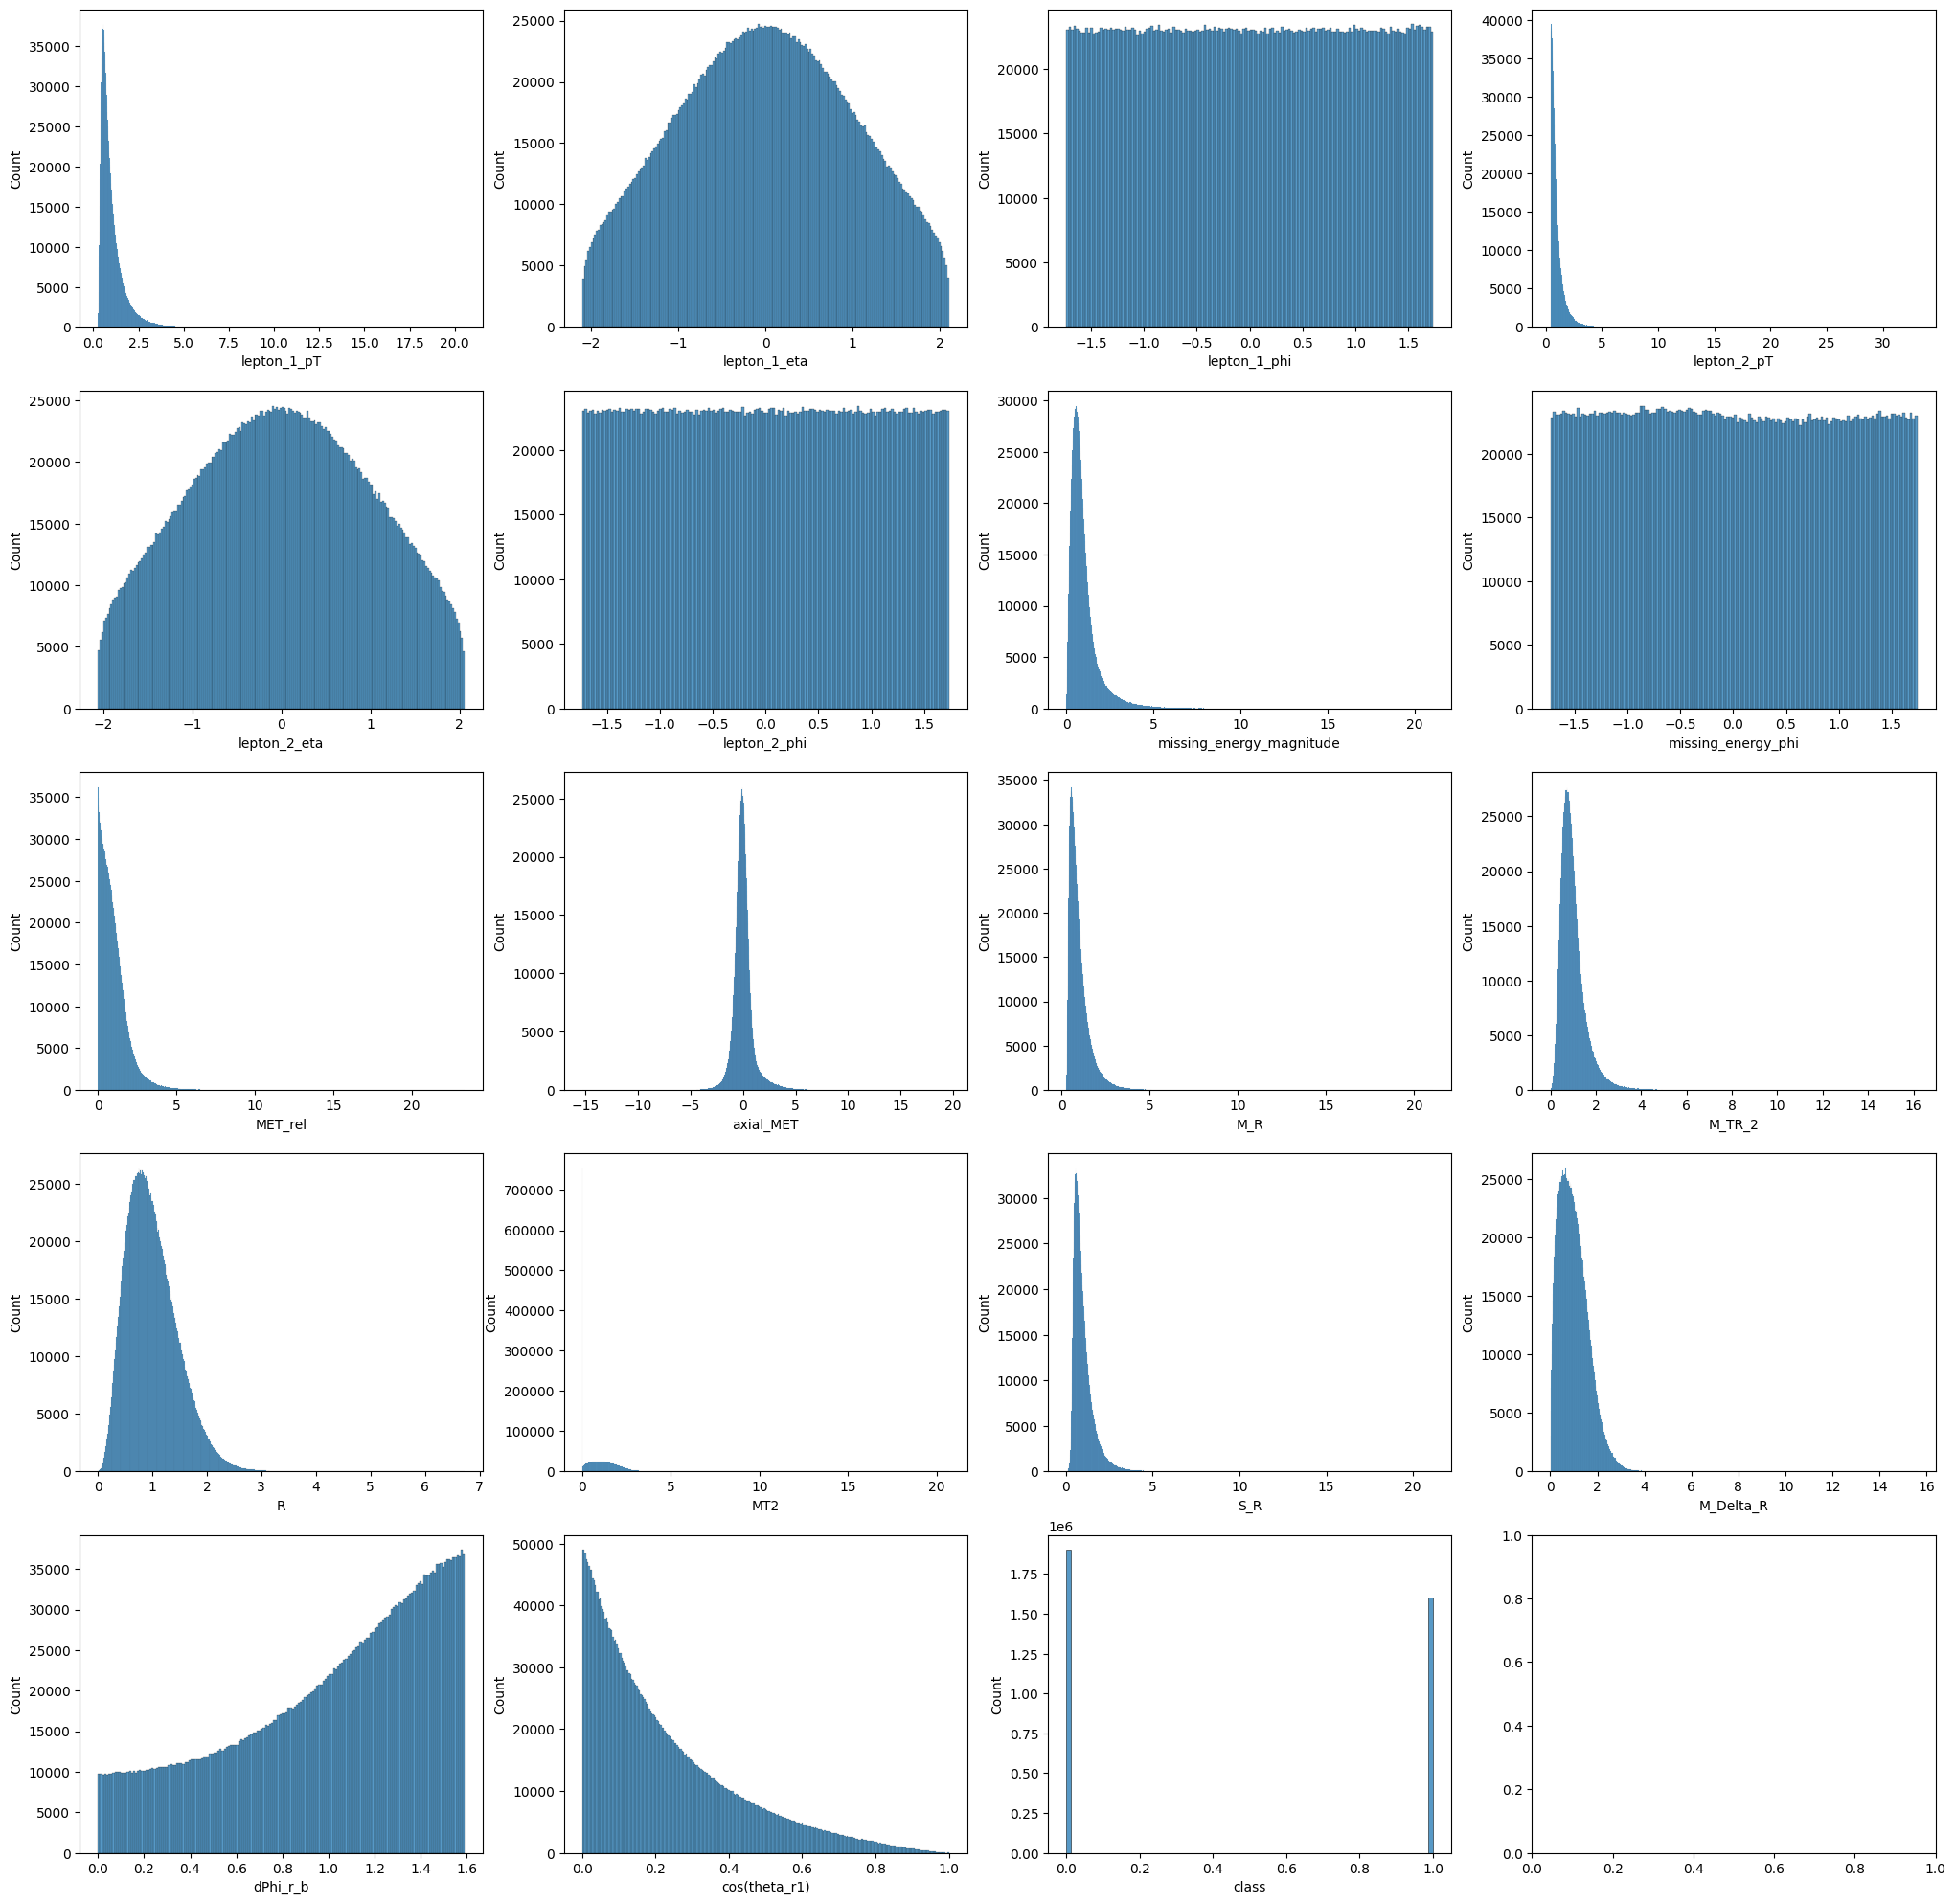

In [68]:
# df.hist(figsize=(25,25))
# plt.show()

# StackOver Flow
n_rows = 5
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25,25))

for i, column in enumerate(df.columns):
    sns.histplot(df[column], ax=axes[i//n_cols,i%n_cols])

plt.show()

We can see that all the columns in the data are numericalm and have weither of four distribution.
* Guassian Distribution
* Left/Right Skewed Guassian Distribution
* Power Law Distribution
* Uniform Distribution

We could try to apply `log_transform` on the skewed distribution to make them normal.

There are no outliers, various box plot are plotted for columns which are normally distributed and there were no outliers.

For the skewed distribution, there are very long tails, but when removed those outliers they were effecting the generalization of any algorithm. So those values were maintained and are not treated as outliers

Note:

Various data trasnformations were applied to change the data, and new columns were derived using the first 8 features. In the paper `Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014)`, they mentioned that three particles are emitted when a collission occurs, and the `lepton_1` and `lepton_2` are the first two particles, and the goal is to find the the third rare particle. For this we can derive new features based on domain knowledge like $e^((lepton_1)^2 + (lepton_2)^2)$.

### Data Split

In [4]:
Y = df['class']
df_train = df.drop('class',axis=1)

YFinal = df_test['class']
XFinal = df_test.drop('class', axis=1)

Xtrain,Xtest,Ytrain,Ytest=train_test_split(df_train, Y, test_size=0.20, random_state=42, shuffle=True)

print(f"Training Data: Shape of Features: {Xtrain.shape}, Shape of Labels: {Xtrain.shape}")
print(f"Testing Data: Shape of Features: {Xtest.shape}, Shape of Labels: {Ytest.shape}")

Training Data: Shape of Features: (2800000, 18), Shape of Labels: (2800000, 18)
Testing Data: Shape of Features: (700000, 18), Shape of Labels: (700000,)


### Abstraction (Helper Functions)

In [59]:
ACCURACIES = dict()
def train_model(model, train_X=Xtrain, train_Y=Ytrain, 
                test_X=Xtest, test_Y=Ytest, **kwargs):
    """
    Train a Model for the given `model` classifier.
    The Train Data X and Y are used for training,
    The testing Data X and Y are used for testing after
    the fitting of the model.

    The kwargs, are for keyword parameters for each model.

    Prints the Training and Validation(testing) Accuracy
    Returns the trained classifier
    """

    global ACCURACIES
    classifier = model(**kwargs, random_state = 42)
    classifier.fit(df_train,Y)

    print("Training Acc: ",classifier.score(train_X, train_Y))
    score = classifier.score(test_X, test_Y)
    print("Val Acc: ", score)

    model_name = type(classifier).__name__
    # Getting the Zeroth Index of the Tuple from the Value
    if ACCURACIES.get(model_name, (0,{}))[0] > score:
        ACCURACIES[model_name] = score, kwargs

    return classifier

In [6]:
def parameter_tuning(model, parameters, trials=100):
    """
    Using Optuna to Tune Hyper parameters.

    The function takes parameters which is a dictinary,
    with all possible arguments to the models and the range or list
    of parameters to be tried for each argument.
    """
    # https://optuna.readthedocs.io/en/v2.0.0/tutorial/pruning.html
    # https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args
    def objective(trial):
        """
        The objective function is to create a function which tries one value of each
        parameter from the dictionary given based on the best possible approach.

        This function also includes pruning algorithms, to stop going ahead with the curernt
        hyper parameters value if the model is not giving better results. Which tries to
        cut down the search time.
        """
        nonlocal parameters, model
        suggest = {'cat': trial.suggest_categorical, 'int': trial.suggest_int,
                'float': trial.suggest_float, 'uni': trial.suggest_uniform}
        params = {}
        for k,v in parameters.items():
            params[k] = suggest[v[0]](k,**v[1])
        clf = model(**params)
        clf.fit(Xtrain, Ytrain)
        if trial.should_prune():
            raise optuna.TrialPruned()

        return clf.score(Xtest, Ytest)


    study = optuna.create_study(
        direction="maximize", pruner=optuna.pruners.SuccessiveHalvingPruner()
    )
    study.optimize(objective, n_trials=trials, n_jobs=-1)

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return trial.params

## Models

### Logistic Regression

In [38]:
# parameters = dict(max_iter = 1000, n_jobs=-1)
# model = train_model(LogisticRegression, **parameters)

Training Acc:  **0.7884857142857142**  
Val Acc:  **0.7877085714285714**

We now have a baseline of **78.77%** validation accuracy.

Logistic Regression is a linear model, which tries to fit the model of seperating the class by a hyper-plane. If the data points is not linearly seprable we have the error, which is evident with error of *0.2123*

### Support Vector Classifier

SVMs scale very poorly with data, here we are having 3.5M data points and even after split we have 2.8M data points. In SVM during solving the dual problem the optimizer evaluates 2.8M langrange variables, out of which many will be zero's and the non-zero are the support vectors. But this will take a lot of time and cross the 1 hour constraint.

### Decision Tree

It was than decided to use a vanilla decision tree, so as to create a simple rule based system derived from the data. This was done primarily to understand the feature dependency on the output. Since the single decision tree is very good to model interpretability.

A more complex problem will reduce interpretability and explainability of the data, and Decision Tree is a good approach to start with to get the data features influence. This may not be the best solution, but a good start to understand.

In [7]:
# parameters = dict(criterion='entropy', max_depth=8)
# model = train_model(DecisionTreeClassifier, **parameters)

Training Acc:  **0.7852380952380953**  
Val Acc:  **0.7816939209726443**

##### Hyper Parameter Tuning (using Optuna)


In [8]:
parameters = dict(
    criterion = ('cat', {'choices':['gini', 'entropy']}),
    max_depth = ('int', dict(low=2, high=32,log=True)),
    splitter = ('cat', {'choices':["best", "random"]}),
    max_features = ('cat', {'choices':[None, "sqrt", "log2"]}),
    ccp_alpha = ('float', dict(low=0, high=0.02, step=0.005)),
)

# best_params = parameter_tuning(DecisionTreeClassifier, parameters, trials = 100)

A new study created in memory with name: no-name-ccce6503-93f1-4e69-bcfb-93504aff439

Trial 0 finished with value: 0.7501951367781156 and parameters: *{'criterion': 'gini', 'max_depth': 6, 'splitter': 'best', 'max_features': 'sqrt', 'ccp_alpha': 0.01}*. Best is trial 0 with value: `0.7501951367781156`  
Trial 1 finished with value: 0.6498364741641337 and parameters: *{'criterion': 'entropy', 'max_depth': 2, 'splitter': 'random', 'max_features': 'log2', 'ccp_alpha': 0.01}*. Best is trial 0 with value: `0.7501951367781156`  
Trial 7 finished with value: 0.6267954407294832 and parameters: *{'criterion': 'gini', 'max_depth': 19, 'splitter': 'random', 'max_features': 'sqrt', 'ccp_alpha': 0.005}*. Best is trial 0 with value: `0.7501951367781156`  
Trial 8 finished with value: 0.7566920972644376 and parameters: *{'criterion': 'gini', 'max_depth': 18, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 8 with value: `0.7566920972644376`  
Trial 11 finished with value: 0.7481306990881459 and parameters: *{'criterion': 'gini', 'max_depth': 14, 'splitter': 'best', 'max_features': 'sqrt', 'ccp_alpha': 0.02}*. Best is trial 8 with value: `0.7566920972644376`  
Trial 12 finished with value: 0.7584814589665654 and parameters: *{'criterion': 'gini', 'max_depth': 5, 'splitter': 'best', 'max_features': 'sqrt', 'ccp_alpha': 0.0}*. Best is trial 12 with value: `0.7584814589665654`  
Trial 13 finished with value: 0.7581580547112462 and parameters: *{'criterion': 'gini', 'max_depth': 4, 'splitter': 'best', 'max_features': 'sqrt', 'ccp_alpha': 0.0}*. Best is trial 12 with value: `0.7584814589665654`  
Trial 22 finished with value: 0.7831367781155015 and parameters: *{'criterion': 'gini', 'max_depth': 11, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 22 with value: `0.7831367781155015`  
Trial 23 finished with value: 0.7501951367781156 and parameters: *{'criterion': 'gini', 'max_depth': 11, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.005}*. Best is trial 22 with value: `0.7831367781155015`  
Trial 42 finished with value: 0.7814951367781156 and parameters: *{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 22 with value: `0.7831367781155015`  
Trial 43 finished with value: 0.7850443768996961 and parameters: *{'criterion': 'gini', 'max_depth': 10, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 43 with value: `0.7850443768996961`  
Trial 44 finished with value: 0.7794395136778115 and parameters: *{'criterion': 'gini', 'max_depth': 12, 'splitter': 'best', 'max_features': 'log2', 'ccp_alpha': 0.0}*. Best is trial 43 with value: `0.7850443768996961`  
Trial 49 finished with value: 0.7845990881458966 and parameters: *{'criterion': 'gini', 'max_depth': 9, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 43 with value: `0.7850443768996961`  
Trial 50 finished with value: 0.7850945288753799 and parameters: *{'criterion': 'gini', 'max_depth': 10, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 50 with value: `0.7850945288753799`  
Trial 51 finished with value: 0.7850145896656535 and parameters: *{'criterion': 'gini', 'max_depth': 10, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 50 with value: `0.7850945288753799`  
Trial 52 finished with value: 0.7850823708206687 and parameters: *{'criterion': 'gini', 'max_depth': 10, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 50 with value: `0.7850945288753799`  
Trial 68 finished with value: 0.7501951367781156 and parameters: *{'criterion': 'gini', 'max_depth': 12, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.005}*. Best is trial 50 with value: `0.7850945288753799`  
Trial 69 finished with value: 0.7792410334346505 and parameters: *{'criterion': 'gini', 'max_depth': 9, 'splitter': 'best', 'max_features': 'sqrt', 'ccp_alpha': 0.0}*. Best is trial 50 with value: `0.7850945288753799`  
Trial 70 finished with value: 0.7805501519756839 and parameters: *{'criterion': 'entropy', 'max_depth': 14, 'splitter': 'random', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 50 with value: `0.7850945288753799`  
Trial 71 finished with value: 0.7851279635258359 and parameters: *{'criterion': 'gini', 'max_depth': 10, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 71 with value: `0.7851279635258359`  
Trial 72 finished with value: 0.7850103343465046 and parameters: *{'criterion': 'gini', 'max_depth': 10, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 71 with value: `0.7851279635258359`  
Trial 73 finished with value: 0.7831857142857143 and parameters: *{'criterion': 'gini', 'max_depth': 11, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 71 with value: `0.7851279635258359`  
Trial 98 finished with value: 0.7845826747720365 and parameters: *{'criterion': 'gini', 'max_depth': 9, 'splitter': 'best', 'max_features': None, 'ccp_alpha': 0.0}*. Best is trial 71 with value: `0.7851279635258359`  
Trial 99 finished with value: 0.730756838905775 and parameters: *{'criterion': 'entropy', 'max_depth': 13, 'splitter': 'random', 'max_features': 'sqrt', 'ccp_alpha': 0.0}*. Best is trial 71 with value: `0.7851279635258359`  
  


```
Best trial:
  Value:  0.7851279635258359  
  Params:    
    * criterion: gini  
    * max_depth: 10  
    * splitter: best  
    * max_features: None  
    * ccp_alpha: 0.0  
  ```

##### After Hyper Parameter Tuning, Training with New Hyperparameters and Evaluating

In [9]:
# model = DecisionTreeClassifier(**best_params)
# model.fit(Xtrain, Ytrain)
# print("Test Acc: ",model.score(Xtest, YFtest))

Test Acc:  **0.7853406666666667**

### Random Forest

Now once we had a Decision Tree, now we can ensemble multiple trees to form a Random Forest. We do this using bagging technique, where the data points are sampled differently for different trees. At the end we get a collection(forest) of trees.

This is done so that we can reduce the variance of the single decisoin tree. This is done using Bagging

In [10]:
# parameters = dict(n_estimators=100, criterion='gini', max_depth = 10, n_jobs=-1)
# model = train_model(RandomForestClassifier, **parameters)

Training Acc:  **0.8043047619047619**  
Val Acc:  **0.7947720364741642**

In [11]:
parameters = dict(
    n_estimators = ('int', dict(low=16, high=512, log=True)),
    max_features = ('float', dict(low=0.15, high=1.0)),
    min_samples_split = ('int', dict(low=2, high=14)),
    min_samples_leaf = ('int', dict(low=1, high=14)),
    max_samples = ('float', dict(low=0.6, high=0.99)),
)

# best_params = parameter_tuning(RandomForestClassifier, parameters, trials = 30)

A new study created in memory with name: no-name-23d7a54f-1a5b-473e-b1b7-05eaae63c4c

Trial 7 finished with value: 0.7980237082066869 and parameters: {'n_estimators': 47, 'max_features': 0.4596051497513195, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_samples': 0.6523800590566861}. Best is trial 7 with value: `0.7980237082066869`

Trial 3 finished with value: 0.7982547112462006 and parameters: {'n_estimators': 87, 'max_features': 0.2981610544019258, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.986226411599963}. Best is trial 3 with value: `0.7982547112462006`

Trial 9 finished with value: 0.7961930091185411 and parameters: {'n_estimators': 23, 'max_features': 0.5739882381756989, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_samples': 0.6803133252458505}. Best is trial 3 with value: `0.7982547112462006`

Trial 4 finished with value: 0.7982899696048632 and parameters: {'n_estimators': 70, 'max_features': 0.9466019600183457, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_samples': 0.8431696250534466}. Best is trial 4 with value: `0.7982899696048632`

Trial 2 finished with value: 0.7992127659574468 and parameters: {'n_estimators': 128, 'max_features': 0.6205302240776256, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_samples': 0.7576130035460769}. Best is trial 2 with value: `0.7992127659574468`

Trial 6 finished with value: 0.7999793313069908 and parameters: {'n_estimators': 189, 'max_features': 0.48541270809179304, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_samples': 0.6770325683419379}. Best is trial 6 with value: `0.7999793313069908`

Trial 12 finished with value: 0.797529179331307 and parameters: {'n_estimators': 39, 'max_features': 0.36246416423360384, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_samples': 0.8976190443329654}. Best is trial 6 with value: `0.7999793313069908`

Trial 13 finished with value: 0.7924936170212766 and parameters: {'n_estimators': 20, 'max_features': 0.9820341311824934, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7134874049550151}. Best is trial 6 with value: `0.7999793313069908`

Trial 8 finished with value: 0.7999866261398176 and parameters: {'n_estimators': 171, 'max_features': 0.5787223768791657, 'min_samples_split': 9, 'min_samples_leaf': 12, 'max_samples': 0.6698039063759819}. Best is trial 8 with value: `0.7999866261398176`

Trial 21 finished with value: 0.798937386018237 and parameters: {'n_estimators': 478, 'max_features': 0.15782017114552138, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_samples': 0.6056404685945235}. Best is trial 8 with value: `0.7999866261398176`

Trial 10 finished with value: 0.8000282674772037 and parameters: {'n_estimators': 333, 'max_features': 0.7400302635544946, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_samples': 0.6199951088017647}. Best is trial 10 with value: `0.8000282674772037`

Trial 17 finished with value: 0.8002747720364741 and parameters: {'n_estimators': 399, 'max_features': 0.7500853374325903, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_samples': 0.61439371842897}. Best is trial 17 with value: `0.8002747720364741`

Trial 18 finished with value: 0.8002969604863222 and parameters: {'n_estimators': 494, 'max_features': 0.7042917092544888, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_samples': 0.6043806165694288}. Best is trial 18 with value: `0.8002969604863222`

Trial 19 finished with value: 0.8003197568389058 and parameters: {'n_estimators': 422, 'max_features': 0.7272347622230614, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_samples': 0.6258827581609802}. Best is trial 19 with value: `0.8003197568389058`

Trial 28 finished with value: 0.8002668693009118 and parameters: {'n_estimators': 401, 'max_features': 0.8224379443199038, 'min_samples_split': 12, 'min_samples_leaf': 14, 'max_samples': 0.630348068431515}. Best is trial 19 with value: `0.8003197568389058`

Trial 29 finished with value: 0.8001954407294832 and parameters: {'n_estimators': 380, 'max_features': 0.8484879439317321, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_samples': 0.6356978721622217}. Best is trial 19 with value: `0.8003197568389058`

```
Best trial:
  Value:  0.8003197568389058
  Params: 
    n_estimators: 422
    max_features: 0.7272347622230614
    min_samples_split: 11
    min_samples_leaf: 12
    max_samples: 0.6258827581609802
```

In [12]:
# model = RandomForestClassifier(**best_params)
# model.fit(Xtrain, Ytrain)
# print("Test Acc: ",model.score(XFinal, YFinal))

Test Acc:  **0.8007433333333334**

### eXtreme Gradient Boosting

At the end, after Random Forest, to have a more robust model which accounts for mis-classification of the points, Boosting was preferred. In boosting, we increaase the probability of the data point being selected if the data point was mis-classified in the previous iteration. We go on perform the iteration repeatedly until we have a robust model.

There were various option of `AdaBoost`, `GradientBoost`, `HistGradientBoost`, `LightGBM` and `eXtremeGradientBoost`. `AdaBoost` is limited to only stumps, which is depth of 1 tree with only 2 leafes to a node.

All other boosting techniques are realted to `Gradient`, and the `eXtremeGradientBoostin` method, uses an Additive Tree learning method ,where we know it is intractable to enumerate all possible tree structures, so we keep on adding one split at a time.

In [13]:
# parameters = dict(n_jobs = -1)
# model = train_model(XGBClassifier, **parameters)

Training Acc:  **0.8047453571428571**  
Val Acc:  **0.8017314285714285**

Optuna was used to do hyper parameter testing, but a GPU was used since XGBoost has GPU compatibility. TheGPU helped in running the various combinartions of parameters quickly. The metric for tuning was Area Under Curve rather than error or accuracy. This was done to increase the model robustness. But once we got the hyper parameters the metric was than kept back as `error` since that is the end objective.

The objective parameter is binary-logistic, since it is a bianry problem which is classification. All the other hyper parameters were given a wide range of search space and the best was selected from that space.

##### Hyper Parameter Tuning

```
 param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2, 1.0),
    }

    param["max_depth"] = trial.suggest_int("max_depth", 1, 15)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
    param["max_delta_step"] = trial.suggest_int("max_delta_step", 0, 20)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-9, 0.5, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    param["scale_pos_weight"] = trial.suggest_categorical("scale_pos_weight", [1.17])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-error")
    history = xgb.cv(param, dtrain, num_boost_round=100, nfold=2, callbacks=[pruning_callback],)
    mean_error = history["test-error-mean"].values[-1]
```

In [65]:
parameters = {
 'objective': 'binary:logistic',
 'eval_metric': 'error',
 'booster': 'gbtree',
 'lambda': 0.5,
 'alpha': 0.5,
 'gamma': 0.05, #min_split_loss
 'tree_method': "hist",
 'learning_rate': 0.0271,
 'max_depth': 10,
 'min_child_weight': 13,
 'max_delta_step': 17,
 'n_estimators': 500,
 'grow_policy': 'depthwise',
 'num_parallel_tree': 4,
 'subsample': 0.8,
 'colsample_bylevel': 0.9,
 'colsample_bytree': 0.45,
#  'scale_pos_weight': 1.17,
 'n_jobs' : -1}
 
model = train_model(XGBClassifier, **parameters)

Training Acc:  0.8087035714285714
Val Acc:  0.8081557142857143


Training Acc:  **0.8102378571428571**  
Val Acc:  **Test Acc:  0.8044013333333333**

### Creating Files

#### Generating CSV

In [55]:
def gen_csv(model):
    df_test = pd.read_csv("./test.csv", index_col=0)
    prediction = model.predict(df_test)
    with open("./prediction.csv", 'w') as f:
        f.write("id,class\n")
        for idx, i in enumerate(prediction):
            f.write(f"{idx},{float(i)}\n")

gen_csv(model)

### Future Work

* The main short coming was domain knowledge, and how to come up with different derived features fromthe existing 8/18 features. The paper entails some mass invariance and momentum, which can be calculated with certain equation from our features.

* Weights and Biases was tried to keep the tracking of experiments. It would be helpful to conenct Optuna and Weights and Biases, so that the hyper parameter tuning and all the experiments, artifacts related to the experiments are stored.